# Example using nltk for TF-IDF clustering

## Methodology

The following data science steps will be demonstrated:

1. Load and process text (for a simplified toy dataset)

2. Vectorize text to a numeric matrix  
(i) Transform input sentences using count vectorizer  
(ii) Transform count vectorizer to a bag-of-words  
(iii) Transform bag-of-words to TF-IDF  
(iv) Build weighted word counts from TF-IDF  
(v) Build cosine similarity of sentences from TF-IDF  
(vi) Build a word cloud from the weighted word counts

3. Dimensionality Reduction using PCA

4. Calculate K-means clusters (unsupervised classification) 







## 1.  Load and process text (for a simplified toy dataset)

**For an example of how to load 'real' data from a file on Google Drive and process the string tokens see: **  
<a href="https://colab.research.google.com/github/gal-a/blog/blob/master/docs/notebooks/nlp/nltk_preprocess.ipynb" target="_blank">Process text files</a>  

In [1]:
# Setup
!pip install -q wordcloud
import wordcloud

import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.decomposition import PCA
from sklearn.manifold import MDS

pd.set_option("display.precision", 4)

# Load toy dataset
dat = [
         ['X', 'aaa aaa'],
         ['Y', 'aaa bbb bbb'],
         ['Y', 'aaa bbb bbb ddd'],
         ['Z', 'aaa bbb ccc eee'],
         ['Z', 'aaa bbb ccc fff']
      ]
df_sentences = pd.DataFrame(dat, columns=['Label', 'Sentence'])

labels = df_sentences['Label']
print("labels:")
print(labels)

n_clusters = np.unique(labels).shape[0]
print("n_clusters:", n_clusters)

labels:
0    X
1    Y
2    Y
3    Z
4    Z
Name: Label, dtype: object
n_clusters: 3


## 2. Vectorize text to a numeric matrix      

In [2]:
# Build tf-idf vectorizer and cosine similarity matrix
def build_vectorizer(sentences, vocab=None, min_df=0.0, max_df=1.0, ngram_range=(1,1)):   # for a 2-gram use: ngram_range=(1,2)
    '''
    Build the tf-idf vectorizer: 
    1. Build the count_vectorizer from the input sentences.
    2. Transform count_vectorizer to bag-of-words.
    3. Fit the transform to the bag-of-words.
    
    Note:
    Alternatively we can do this directly with 'TfidfVectorizer' instead of using 'CountVectorizer' followed by 'TfidfTransformer'
    
    Return:
    cvec, feature_names, df_bag_of_words, tfidf, df_weights, cos_sim, samp_dist
    '''
    
    # Build count vectorizer
    count_vectorizer = CountVectorizer(max_df=max_df, min_df=min_df, vocabulary=vocab, ngram_range=(1,1))  # stop_words='english, max_features=N_FEATURES 
    cvec = count_vectorizer.fit(sentences)

    # Get feature names
    feature_names = cvec.get_feature_names()

    # Get bag-of-words and analyze
    bag_of_words = cvec.transform(sentences)
    df_bag_of_words = pd.DataFrame(bag_of_words.todense(), columns=feature_names)
    
    # Transform bag_of_words into tf-idf matrix
    transformer = TfidfTransformer()
    tfidf = transformer.fit_transform(bag_of_words)

    # Find most popular words and highest weights
    word_cnts = np.asarray(bag_of_words.sum(axis=0)).ravel().tolist()  # for each word in column, sum all row counts
    df_cnts = pd.DataFrame({'word': feature_names, 'count': word_cnts})
    df_cnts = df_cnts.sort_values('count', ascending=False)

    # Build word weights as a list and sort them
    weights = np.asarray(tfidf.mean(axis=0)).ravel().tolist()
    df_weights = pd.DataFrame({'word': feature_names, 'weight': weights})
    df_weights = df_weights.sort_values('weight', ascending=False)

    df_weights = df_weights.merge(df_cnts, on='word', how='left')
    df_weights = df_weights[['word', 'count', 'weight']]

    # Cosine similarity of sentences
    cos_sim = cosine_similarity(tfidf, tfidf)

    # Distance matrix of sentences
    samp_dist = 1 - cos_sim

    return cvec, feature_names, df_bag_of_words, tfidf, df_weights, cos_sim, samp_dist
  
# Build
sentences = df_sentences['Sentence'].values.tolist()
cvec, feature_names, df_bag_of_words, tfidf, df_weights, cos_sim, samp_dist = build_vectorizer(sentences)

df_tfidf = pd.DataFrame(tfidf.todense(), columns=feature_names)

print("%d dummy sentences:" % len(sentences))
print(sentences)
print("---")
print("%d feature_names (each feature represents a distinct word):" % len(feature_names))
print(feature_names)
print("---")
print("df_tfidf[%d,%d]:" % (len(sentences), len(feature_names)))
print(df_tfidf.to_string())
print("---")
print("df_weights:")
print(df_weights)
print("---")
print("cos_sim[%d,%d] (a square matrix of length and width = len(sentences)):" % (len(sentences), len(sentences)))
print(cos_sim)

5 dummy sentences:
['aaa aaa', 'aaa bbb bbb', 'aaa bbb bbb ddd', 'aaa bbb ccc eee', 'aaa bbb ccc fff']
---
6 feature_names (each feature represents a distinct word):
['aaa', 'bbb', 'ccc', 'ddd', 'eee', 'fff']
---
df_tfidf[5,6]:
      aaa     bbb     ccc     ddd     eee     fff
0  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000
1  0.3895  0.9210  0.0000  0.0000  0.0000  0.0000
2  0.3016  0.7131  0.0000  0.6329  0.0000  0.0000
3  0.3216  0.3802  0.5445  0.0000  0.6749  0.0000
4  0.3216  0.3802  0.5445  0.0000  0.0000  0.6749
---
df_weights:
  word  count  weight
0  bbb      6  0.4789
1  aaa      6  0.4669
2  ccc      2  0.2178
3  eee      1  0.1350
4  fff      1  0.1350
5  ddd      1  0.1266
---
cos_sim[5,5] (a square matrix of length and width = len(sentences)):
[[1.         0.38949927 0.30157015 0.32159819 0.32159819]
 [0.38949927 1.         0.77425086 0.47546655 0.47546655]
 [0.30157015 0.77425086 1.         0.36813039 0.36813039]
 [0.32159819 0.47546655 0.36813039 1.         0.5444966

**Note how the above cosine similarity matrix corresponds to the original bag-of-words representation shown below:  **

* Row 0 cosine similarity values are not similar to rows 1 to 4  
* Rows 1 and 2 contain similar values (they are not identical due to the extra word in row 2: 'ddd')
* Rows 3 and 4 contain identical values (with columns 3 and 4 shifted)

## Bag-of-words
The bag-of-words representation will usually be sparser than this one (i.e. lots of zero values) since each sentence contains only a few of the words from the entire corpus

In [3]:
print("df_bag_of_words[%d,%d]:" % (len(sentences), len(feature_names)))
print(df_bag_of_words)

df_bag_of_words[5,6]:
   aaa  bbb  ccc  ddd  eee  fff
0    2    0    0    0    0    0
1    1    2    0    0    0    0
2    1    2    0    1    0    0
3    1    1    1    0    1    0
4    1    1    1    0    0    1


## Build a word cloud from the weighted word counts

  word  count  weight
0  bbb      6  0.4789
1  aaa      6  0.4669
2  ccc      2  0.2178
3  eee      1  0.1350
4  fff      1  0.1350
5  ddd      1  0.1266
---
di_word_freq:
bbb 6
aaa 6
ccc 2
eee 1
fff 1
ddd 1


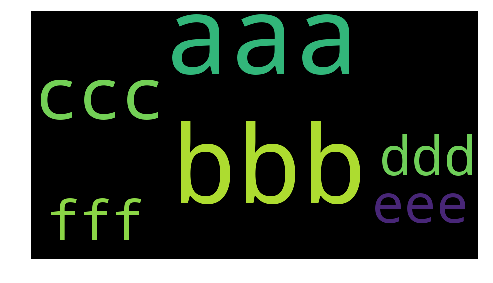

In [4]:
print(df_weights)
s_word_freq = pd.Series(df_weights['count'])
s_word_freq.index = df_weights['word']
di_word_freq = s_word_freq.to_dict()

print("---")
print("di_word_freq:")
for k,v in di_word_freq.items():
  print(k,v)

cloud = wordcloud.WordCloud(width=900, height=500).generate_from_frequencies(di_word_freq)
plt.imshow(cloud)
plt.axis('off')
plt.show()

## 3. Dimensionality Reduction using PCA

Before attempting to cluster the data, we will usually want to reduce the dimensionality of the data because this helps to mitigate the problem of overfitting. Note the distinction between the two terms:

* Dimensionality reduction: find the linear combinations of variables that are most 'interesting' in the data. For example, the polular PCA technique finds linear transformations of input features that maximize the variance of the data points along the new axes.

* Clustering: find data points that can be grouped together as separate classes.

In [5]:
# Dimensionality reduction using PCA, reduce the tfidf matrix to just 2 features
X = tfidf.todense()
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

print("X_pca now has just 2 columns:")
print(X_pca)

X_pca now has just 2 columns:
[[-0.33479819  0.70798379]
 [ 0.41621679 -0.01261977]
 [ 0.57969288  0.01365307]
 [-0.33055574 -0.35450854]
 [-0.33055574 -0.35450854]]


##4. Calculate K-means clusters (unsupervised classification) 

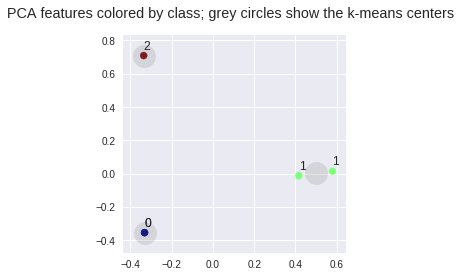

In [10]:
km_model = KMeans(n_clusters=n_clusters, max_iter=10, n_init=2, random_state=0)

# K-means (from number of features in input matrix to n_clusters)
km_model.fit(X_pca)
df_centers = pd.DataFrame(km_model.cluster_centers_, columns=['x', 'y'])

plt.figure(figsize=(4,4))
plt.suptitle('PCA features colored by class; grey circles show the k-means centers')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=km_model.labels_, s=50, cmap='jet')
plt.scatter(df_centers['x'], df_centers['y'], c='grey', s=500, alpha=0.2);

dy = 0.04
for i, txt in enumerate(km_model.labels_):
    plt.annotate(txt, (X_pca[i, 0], X_pca[i, 1] + dy))


In [7]:
print("km_model.labels_:", km_model.labels_)
print("This corresponds to the sentence labels shown below as follows:")
print(df_sentences['Label'].tolist())
print("---")
print("df_centers:")
print(df_centers)

km_model.labels_: [2 1 1 0 0]
This corresponds to the sentence labels shown below as follows:
['X', 'Y', 'Y', 'Z', 'Z']
---
df_centers:
        x       y
0 -0.3306 -0.3545
1  0.4980  0.0005
2 -0.3348  0.7080


**Note above how the center coordinates for the k-means model correspond to the original sentences shown below. The dimensions of the centers are: (n_clusters, n_features). Each row corresponds to one of the sentences. We often run PCA as the first step and therefore end up with 2 remaining features (n_features = 2). **

In [8]:
print(df_sentences)

  Label         Sentence
0     X          aaa aaa
1     Y      aaa bbb bbb
2     Y  aaa bbb bbb ddd
3     Z  aaa bbb ccc eee
4     Z  aaa bbb ccc fff


## Summary

The following data science techniques were demonstrated in the context of NLP (Natural Language Processing) using python's nltk library:

* Vectorize text to a numeric matrix using TF-IDF

* Dimensionality Reduction using PCA

* Calculate K-means clusters (unsupervised classification) 